# Satellite Image Embedding Extraction
## Multimodal Property Valuation

Objective:
- Extract fixed visual embeddings from satellite images
- Use a pretrained CNN as a feature extractor
- Save embeddings for multimodal fusion


In [10]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models, transforms
from tqdm import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
IMAGE_DIR = "/content/drive/MyDrive/IIT_Roorkee_Project/images/"
DATA_PATH = "/content/drive/MyDrive/IIT_Roorkee_Project/data/"

print("Number of images:", len(os.listdir(IMAGE_DIR)))


Number of images: 21436


In [12]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [13]:
cnn = models.resnet18(pretrained=True)

# Remove final classification layer
cnn = nn.Sequential(*list(cnn.children())[:-1])

# Freeze all CNN parameters
for param in cnn.parameters():
    param.requires_grad = False

device = "cuda" if torch.cuda.is_available() else "cpu"
cnn = cnn.to(device)
cnn.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [14]:
from torch.utils.data import Dataset, DataLoader

class SatelliteDataset(Dataset):
    def __init__(self, image_dir, image_files, transform):
        self.image_dir = image_dir
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, img_name


In [15]:
image_files = sorted(os.listdir(IMAGE_DIR))

dataset = SatelliteDataset(
    IMAGE_DIR,
    image_files,
    image_transform
)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [16]:
embeddings = []
image_ids = []

with torch.no_grad():
    for images, names in tqdm(loader):
        images = images.to(device)

        batch_emb = cnn(images)
        batch_emb = batch_emb.view(batch_emb.size(0), -1)
        batch_emb = batch_emb.cpu().numpy()

        embeddings.append(batch_emb)
        image_ids.extend(names)

embeddings = np.vstack(embeddings)

print("Embedding shape:", embeddings.shape)


100%|██████████| 335/335 [09:09<00:00,  1.64s/it]

Embedding shape: (21436, 512)


In [17]:
np.save(DATA_PATH + "image_embeddings.npy", embeddings)

pd.DataFrame({
    "image_id": image_ids
}).to_csv(DATA_PATH + "image_ids.csv", index=False)


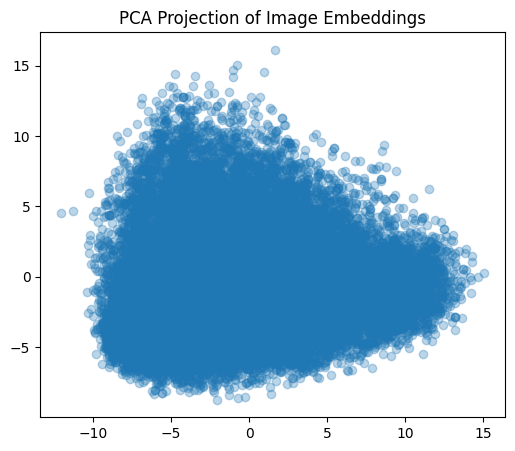

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6,5))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.3)
plt.title("PCA Projection of Image Embeddings")
plt.show()


### Image Embedding Summary

- Used pretrained ResNet18 as a fixed feature extractor
- Extracted 512-dimensional embeddings per property
- CNN weights frozen to prevent overfitting
- Saved embeddings for multimodal fusion
